<a href="https://colab.research.google.com/github/am-tropin/georgian-letters-trainer/blob/main/Georgian_letters_recognition_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GEORGIAN ALPHABET: IMAGE PROCESSING and CLASSIFICATION with CNN**

This notebook contains 2 independent parts:

- 1. Image processing of the Georgian dataset
- 2. Training and evaluating the CNN model

# **1. Image processing of the Georgian dataset**

In [1]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import cv2
import xml.etree.ElementTree as ET # for parsing XML files

import pandas as pd
import numpy as np
import re

import glob
import os
import shutil

from google.colab.patches import cv2_imshow
from google.colab import files

# import sys, random
# from shutil import copyfile

## **1.1. Downloading the original dataset**

In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/alexandertropin/georgian-letters-photo-database", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alexandertropin
Your Kaggle Key: ··········


100%|██████████| 208M/208M [00:05<00:00, 41.2MB/s]


In [12]:
def to_extract_coordinates(source_folder, target_name):
    annotations = glob.glob(source_folder + '*.xml')

    df = []
    cnt = 0

    for file in annotations:
        filename = file.split('/')[-1].split('.')[0] + '.jpg'
        row = []
        parsedXML = ET.parse(file)
        for node in parsedXML.getroot().iter('object'):
            letters = node.find('name').text
            xmin = int(node.find('bndbox/xmin').text)
            xmax = int(node.find('bndbox/xmax').text)
            ymin = int(node.find('bndbox/ymin').text)
            ymax = int(node.find('bndbox/ymax').text)

            row = [filename, letters, xmin, xmax, ymin, ymax]
            df.append(row)
            cnt += 1

    data = pd.DataFrame(df, columns=['file_name', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax'])

    data[['file_name', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv(target_name + '.csv', index=False)
    return 1

In [13]:
source_folder = 'georgian-letters-photo-database/georgian_letters_image_database/dataset/'
target_name = 'label_coordinates'

to_extract_coordinates(source_folder, target_name)

1

In [15]:
df = pd.read_csv('label_coordinates.csv')
df = df.sort_values(['file_name', 'letter_name'])
df.head()

,file_name,letter_name,xmin,xmax,ymin,ymax
892,IMG_20220404_150259.jpg,0ა,1284,1372,931,1061
897,IMG_20220404_150259.jpg,0ა,1880,1972,974,1088
906,IMG_20220404_150259.jpg,0ა,2820,2900,1029,1137
914,IMG_20220404_150259.jpg,0ა,924,1016,1106,1229
919,IMG_20220404_150259.jpg,0ა,1459,1549,1141,1267


In [8]:
df.shape

(4020, 6)

## **1.2. Cutting images into black and white resized letters**

In [25]:
def invert_image(img, border_radius):
    '''
    The function is for inverting colors on black and white images if the background is black. 
    '''

    height, width = img.shape[:2]
    # border_radius = 0.03 # border neighborhood radius in percent

    # mean grayscale value
    # mean_image = np.mean(img)
    # mean grayscale value in the image center 
    mean_image = np.mean(img[int(height*border_radius):int(height*(1-border_radius)), int(width*border_radius):int(width*(1-border_radius))])

    # mean grayscale values near the borders
    mean_left_border = np.mean(img[:, int(width*(1-border_radius)):width])
    mean_right_border = np.mean(img[:, 0:int(width*border_radius)])
    mean_upper_border = np.mean(img[0:int(height*border_radius), :])
    mean_lower_border = np.mean(img[int(height*(1-border_radius)):height, :])

    if mean_image > np.mean(np.array([mean_left_border, mean_right_border, mean_upper_border, mean_lower_border])):
        return cv2.bitwise_not(img)
    else:
        return img


In [26]:
def to_crop_letters(df, imread_dict, source_folder, target_folder, width, height, border_radius):
    '''
    The function is for cropping given images into small images with singular black letters on the white background.

    Parameters:
    - df            - a dataframe with columns 'file_name', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax'
    - imread_dict   - a dictionary with a name of image file as a key and its cv2.imread object as a value
    - source_folder - a folder where images are located
    - target_folder - a folder where cropped images will be saved
    - width         - a width of a cropped image
    - height        - a height of a cropped image
    - border_radius - a radius (in percent) of border for checking the color of background
    '''

    # letter_names = set(list(df['letter_name']))

    # a counter of letters within each image
    letter_counter = {}

    for index, row in df.iterrows():
        if row['file_name'] in letter_counter.keys():
            if row['letter_name'] in letter_counter[row['file_name']].keys():
                letter_counter[row['file_name']][row['letter_name']] += 1
            else:
                letter_counter[row['file_name']][row['letter_name']] = 1
        else:
            letter_counter[row['file_name']] = {}
            letter_counter[row['file_name']][row['letter_name']] = 1

        # img = cv2.imread(source_folder + row['file_name'])
        img = imread_dict[row['file_name']]
        crop_img = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
        try:
            crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
            crop_img = cv2.threshold(crop_img, np.mean(crop_img), 255, cv2.THRESH_BINARY)[1]
            crop_img = invert_image(crop_img, border_radius)
            final_img = cv2.resize(crop_img, (width, height))
            # thresh_img = invert_img
        except:
            final_img = crop_img
            print(row)
        # thresh_img = cv2.threshold(invert_img, (np.amin(invert_img) + np.amax(invert_img))//2, 255, cv2.THRESH_BINARY)[1]
        # 127, 255
        # cv2.THRESH_BINARY: If pixel intensity is greater than the set threshold, value set to 255, else set to 0 (black).
        cv2.imwrite(target_folder + row['file_name'][:-4] + '_' + row['letter_name'][-1] + '_' + str(letter_counter[row['file_name']][row['letter_name']]) + '.jpg', final_img)
    return 1

In [11]:
!mkdir cropped_images

Creating a new dataset of images with singular letters:

- Black letter on the white background (inverted if the border neighborhood is darker than the image on the average).
- Resized to 32x32.



In [31]:
df_short = df #.head(100)

# the folder where images are located
source_folder = 'georgian-letters-photo-database/georgian_letters_image_database/dataset/'

imread_dict = {f: cv2.imread(source_folder + f) for f in list(set(list(df['file_name'])))}
# 16 sec for 46 images, that is 1/3 sec for reading 1 image

# the folder where cropped images will be saved
target_folder = 'cropped_images/'

my_height, my_width = 32, 32
# 96, 64
# 100, 150
border_radius = 0.05

to_crop_letters(df_short, imread_dict, source_folder, target_folder, my_width, my_height, border_radius) 

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1

In [ ]:
# files = glob.glob('cropped_images/*')
# for f in files:
#     os.remove(f)

## **1.3. Final check: manual editing of some images**

Downloading the cropped images:

In [28]:
!zip -r /content/cropped_images.zip /content/cropped_images

files.download("/content/cropped_images.zip")

updating: content/cropped_images/ (stored 0%)
updating: content/cropped_images/IMG_20230213_174613_ლ_4.jpg (stored 0%)
updating: content/cropped_images/IMG_20230424_114451_ბ_2.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_144856_ო_6.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_144856_ტ_1.jpg (stored 0%)
updating: content/cropped_images/IMG_20220526_123129_ზ_3.jpg (stored 0%)
updating: content/cropped_images/IMG_20230226_135514_გ_3.jpg (stored 0%)
updating: content/cropped_images/IMG_20230312_144621_ა_3.jpg (stored 0%)
updating: content/cropped_images/IMG_20230215_135956 (1)_დ_6.jpg (stored 0%)
updating: content/cropped_images/IMG_20230215_140110 (1)_ვ_1.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_142943-2_ა_12.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_142943-2_ი_22.jpg (stored 0%)
updating: content/cropped_images/IMG_20230215_134920 (1)_ი_3.jpg (stored 0%)
updating: content/cropped_images/IMG_20230228_202054_ბ_1.jpg

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After looking at cropped dataset I need to invert colors for 5 cropped images manually:

In [32]:
custom_invert_images = [
    'IMG_20230213_212238_ა_2',
    'IMG_20230213_212238_ა_3',
    'IMG_20230215_135956 (1)_ა_5',
    'IMG_20230215_135956 (1)_ვ_2',
    'IMG_20230426_162029_ხ_1'
]

for im in custom_invert_images:
    file_path = '/content/cropped_images/' + im + '.jpg'
    img = cv2.imread(file_path)
    # print(file_path)
    # cv2_imshow(img)
    cv2.imwrite(file_path, cv2.bitwise_not(img))


Some pictures have dual background, so I remove the image with a lot of reject:

In [33]:
dir_list = os.listdir("cropped_images/")

for d in dir_list:
    if 'IMG_20230215_135136 (1)' in d:
    # or 'IMG_20230423_110503_ე_4' in d
        os.remove('/content/cropped_images/' + d)

I download the fixed dataset to upload it in my GitHub repo:

In [38]:
# !cd cropped_images
!zip -r /content/cropped_images.zip /content/cropped_images

files.download("/content/cropped_images.zip")

updating: content/cropped_images/ (stored 0%)
updating: content/cropped_images/IMG_20230213_174613_ლ_4.jpg (stored 0%)
updating: content/cropped_images/IMG_20230424_114451_ბ_2.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_144856_ო_6.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_144856_ტ_1.jpg (stored 0%)
updating: content/cropped_images/IMG_20220526_123129_ზ_3.jpg (stored 0%)
updating: content/cropped_images/IMG_20230226_135514_გ_3.jpg (stored 0%)
updating: content/cropped_images/IMG_20230312_144621_ა_3.jpg (stored 0%)
updating: content/cropped_images/IMG_20230215_135956 (1)_დ_6.jpg (stored 0%)
updating: content/cropped_images/IMG_20230215_140110 (1)_ვ_1.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_142943-2_ა_12.jpg (stored 0%)
updating: content/cropped_images/IMG_20230425_142943-2_ი_22.jpg (stored 0%)
updating: content/cropped_images/IMG_20230215_134920 (1)_ი_3.jpg (stored 0%)
updating: content/cropped_images/IMG_20230228_202054_ბ_1.jpg

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **2. Training and evaluating the CNN model**

In [19]:
import glob
import os
import shutil
import re
from collections import Counter
import numpy as np


## **2.1. Downloading the cropped dataset again**

In [3]:
!wget https://github.com/am-tropin/georgian-letters-trainer/blob/main/cropped_images.zip
# !unzip /content/cropped_images.zip
!unzip /cropped_images.zip

--2023-04-27 13:46:16--  https://github.com/am-tropin/georgian-letters-trainer/blob/main/cropped_images.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘cropped_images.zip’

cropped_images.zip      [ <=>                ] 137.00K  --.-KB/s    in 0.02s   

2023-04-27 13:46:17 (5.73 MB/s) - ‘cropped_images.zip’ saved [140288]

unzip:  cannot find or open /cropped_images.zip, /cropped_images.zip.zip or /cropped_images.zip.ZIP.


I need to detect the **most frequent** Georgian letters in my cropped dataset. 

After looking at a result I will use top-7 letters (about 200+ occurrences each).

In [8]:
crop_dir = "/content/content/cropped_images/"
# crop_dir = "/content/cropped_images/"
dir_list = os.listdir(crop_dir)

letter_list = [re.findall("\_(.)\_", d)[0] for d in dir_list if re.findall("\_(.)\_", d)]

letter_counter = Counter(letter_list)
letter_counter.most_common()

[('ი', 560),
 ('ა', 535),
 ('ე', 336),
 ('რ', 250),
 ('ს', 248),
 ('ო', 222),
 ('ლ', 195),
 ('ნ', 158),
 ('მ', 138),
 ('დ', 135),
 ('ბ', 131),
 ('უ', 130),
 ('ვ', 118),
 ('თ', 100),
 ('ტ', 98),
 ('გ', 86),
 ('კ', 71),
 ('ქ', 60),
 ('შ', 59),
 ('ფ', 57),
 ('ხ', 53),
 ('პ', 53),
 ('ზ', 47),
 ('ც', 43),
 ('წ', 25),
 ('ღ', 19),
 ('ყ', 15),
 ('ძ', 14),
 ('ჩ', 12),
 ('ჭ', 12),
 ('ჯ', 11),
 ('ჟ', 5),
 ('ჰ', 4)]

I need to extract some images for predicting dataset. I chose the image with several most frequent letters printed by a unique font.

In [9]:
!mkdir cropped_images_predict

dir_list = os.listdir(crop_dir)
for d in dir_list:
    if 'IMG_20230315_001116' in d:
        shutil.move(crop_dir + d, '/content/cropped_images_predict/' + d)


mkdir: cannot create directory ‘cropped_images_predict’: File exists


In [10]:
!mkdir cropped_images_fit

dir_list = os.listdir(crop_dir)
for d in dir_list:
    shutil.move(crop_dir + d, '/content/cropped_images_fit/' + d)


## **2.2. Distributing images by train, test and validation folders for each of top-7 letters**


I need to create separate folders for 7 most frequent letters.
<!-- and another one for the others. -->

In [11]:
treshold = 190

head_letter_dict = {x: count for x, count in Counter(letter_list).items() if count >= treshold}
head_letter_dict = {k: v for k, v in sorted(head_letter_dict.items(), key=lambda item: item[1], reverse=True)}
head_letter_dict

{'ი': 560, 'ა': 535, 'ე': 336, 'რ': 250, 'ს': 248, 'ო': 222, 'ლ': 195}

In [13]:
base_dir = 'grouped_images'
os.mkdir(base_dir)

for letter in head_letter_dict.keys():
    os.mkdir(base_dir + '/letter_' + letter)

In [14]:
for letter in head_letter_dict.keys():
    fileList = [f for f in glob.glob("cropped_images_fit/*.jpg") if letter in f]
    for filePath in fileList:
        filePath_splitted = filePath.split('/')
        shutil.copyfile(filePath, 'grouped_images/letter_'+letter+'/' + filePath_splitted[1])


In [15]:
base_dir = 'grouped_images'
dataset_types = ["train", "validation", "test"]

In [17]:
for t in dataset_types:
    t_dir = os.path.join(base_dir, t)
    os.mkdir(t_dir)
    for letter in head_letter_dict.keys():
        t_letter_dir = os.path.join(t_dir, letter)
        os.mkdir(t_letter_dir)


In [20]:
letter_sizes = {}

for letter, amount in head_letter_dict.items():
    letter_sizes[letter] = {}
    letter_sizes[letter]['test'] = int(np.floor(amount * 0.2))
    letter_sizes[letter]['validation'] = int(np.floor((amount - letter_sizes[letter]['test']) * 0.2))
    letter_sizes[letter]['train'] = amount - (letter_sizes[letter]['test'] + letter_sizes[letter]['validation'])
    # print(head_letter_dict[letter])

letter_sizes

{'ი': {'test': 112, 'validation': 89, 'train': 359},
 'ა': {'test': 107, 'validation': 85, 'train': 343},
 'ე': {'test': 67, 'validation': 53, 'train': 216},
 'რ': {'test': 50, 'validation': 40, 'train': 160},
 'ს': {'test': 49, 'validation': 39, 'train': 160},
 'ო': {'test': 44, 'validation': 35, 'train': 143},
 'ლ': {'test': 39, 'validation': 31, 'train': 125}}

In [21]:
for letter in head_letter_dict.keys():
    file_names = [f.split('/')[-1] for f in os.listdir('grouped_images/letter_' + letter)]

    test_names = file_names[:letter_sizes[letter]['test']]
    validation_names = file_names[letter_sizes[letter]['test']:letter_sizes[letter]['test']+letter_sizes[letter]['validation']]
    train_names = file_names[-letter_sizes[letter]['train']:]

    original_dir = 'grouped_images/letter_' + letter

    for f in test_names:
        target_dir = 'grouped_images/test/' + letter
        src = os.path.join(original_dir, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)

    for f in validation_names:
        target_dir = 'grouped_images/validation/' + letter
        src = os.path.join(original_dir, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)

    for f in train_names:
        target_dir = 'grouped_images/train/' + letter
        src = os.path.join(original_dir, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)


## **2.3. Training the CNN model**


In [42]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam

from tensorflow import keras
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow


In [24]:
my_height, my_width = 32, 32


In [25]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(my_height, my_width, 1)))
model.add(Conv2D(16, (3, 3), activation='relu')) # , padding='same'
# model.add(MaxPool2D((2, 2), strides=2))
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2), strides=2))
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(16, (3, 3), activation='relu', padding='valid'))
# model.add(MaxPool2D((2, 2), strides=2))
# model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax')) # sigmoid # 1
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                  

In [26]:
# Configuring the model for training

model.compile(loss='categorical_crossentropy', # binary_crossentropy 
              # sparse_categorical_crossentropy - 8 classes
              # categorical_crossentropy - 7 classes
              optimizer=keras.optimizers.Adam(), 
              # optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), 
              metrics=['accuracy']
              )


In [27]:
# Data Preprocessing

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'), 
    target_size=(my_height, my_width), 
    batch_size=8, 
    class_mode='categorical', 
    color_mode = 'grayscale'
)
validation_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'), 
    target_size=(my_height, my_width), 
    batch_size=1, 
    class_mode='categorical', 
    color_mode = 'grayscale'
) # was: batch_size=20

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 1499 images belonging to 7 classes.
Found 372 images belonging to 7 classes.
data batch shape: (8, 32, 32, 1)
labels batch shape: (8, 7)


In [28]:
# Fit the Model
history = model.fit(train_generator, epochs=4, validation_data=validation_generator)
# steps_per_epoch=5, 
# , validation_steps=50
# about parameters: https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps

# Save the Model
model.save('geo_letters_top8.h5')

Epoch 1/4
188/188 [==============================] - 8s 33ms/step - loss: 0.6280 - accuracy: 0.7805 - val_loss: 0.1576 - val_accuracy: 0.9731
Epoch 2/4
188/188 [==============================] - 5s 27ms/step - loss: 0.0935 - accuracy: 0.9746 - val_loss: 0.0994 - val_accuracy: 0.9812
Epoch 3/4
188/188 [==============================] - 5s 28ms/step - loss: 0.0499 - accuracy: 0.9887 - val_loss: 0.1121 - val_accuracy: 0.9839
Epoch 4/4
188/188 [==============================] - 8s 40ms/step - loss: 0.0354 - accuracy: 0.9913 - val_loss: 0.1297 - val_accuracy: 0.9651


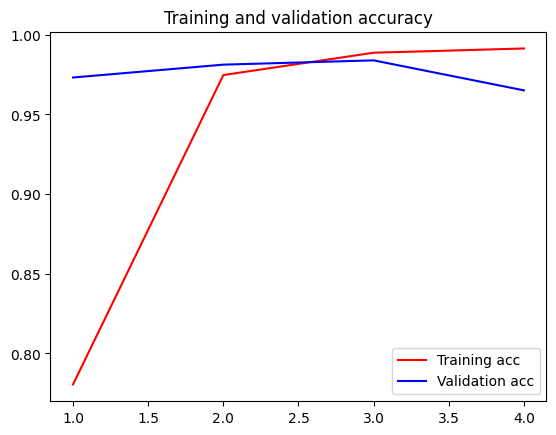

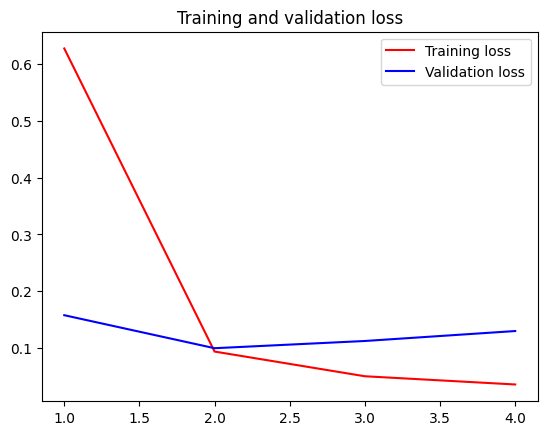

In [31]:
# Displaying curves of loss and accuracy during training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [32]:
history.history

{'loss': [0.6279668211936951,
  0.09347975999116898,
  0.04991413652896881,
  0.03541938588023186],
 'accuracy': [0.7805203199386597,
  0.9746497869491577,
  0.9886590838432312,
  0.9913275241851807],
 'val_loss': [0.15759234130382538,
  0.0993855819106102,
  0.1121130883693695,
  0.12966106832027435],
 'val_accuracy': [0.9731183052062988,
  0.9811828136444092,
  0.9838709831237793,
  0.9650537371635437]}

## **2.4. Predicting for an external image**

In [38]:
# top-7 in lexicographic order
lexico_list = sorted(head_letter_dict.keys(), reverse=False)
lexico_geo_dict = {lexico_list.index(a):a for a in lexico_list}
lexico_geo_dict

# lexico_geo_dict = {0:'ა', 1:'ე', 2:'ი', 3:'ლ', 4:'ო', 5:'რ', 6:'ს'}
# 'ა' - 0, 'ე' - 4, 'ი' - 8, 'ლ' - 10, 'ო' - 13, 'რ' - 16, 'ს' - 17

{0: 'ა', 1: 'ე', 2: 'ი', 3: 'ლ', 4: 'ო', 5: 'რ', 6: 'ს'}

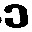

1/1 [==============================] - 0s 55ms/step
The letter on the image is ე
RECOGNIZED CORRECTLY: ე



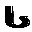

1/1 [==============================] - 0s 41ms/step
The letter on the image is ს
RECOGNIZED CORRECTLY: ს



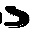

1/1 [==============================] - 0s 37ms/step
The letter on the image is ა
RECOGNIZED CORRECTLY: ა



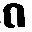

1/1 [==============================] - 0s 36ms/step
The letter on the image is ი
RECOGNIZED CORRECTLY: ი



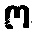

1/1 [==============================] - 0s 32ms/step
The letter on the image is ო
RECOGNIZED CORRECTLY: ო



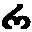

1/1 [==============================] - 0s 33ms/step
The letter on the image is რ
RECOGNIZED CORRECTLY: რ



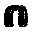

1/1 [==============================] - 0s 64ms/step
The letter on the image is ი
RECOGNIZED CORRECTLY: ი



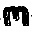

1/1 [==============================] - 0s 42ms/step
The letter on the image is ო
RECOGNIZED CORRECTLY: ო



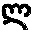

1/1 [==============================] - 0s 60ms/step
The letter on the image is ლ
RECOGNIZED CORRECTLY: ლ



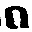

1/1 [==============================] - 0s 40ms/step
The letter on the image is ი
RECOGNIZED CORRECTLY: ი



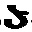

1/1 [==============================] - 0s 41ms/step
The letter on the image is ა
RECOGNIZED CORRECTLY: ა



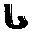

1/1 [==============================] - 0s 39ms/step
The letter on the image is ს
RECOGNIZED CORRECTLY: ს



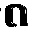

1/1 [==============================] - 0s 27ms/step
The letter on the image is ი
RECOGNIZED CORRECTLY: ი



In [48]:
pred_folder = "cropped_images_predict/"

pred_dir_list = os.listdir(pred_folder)
pred_letter_list = [re.findall("\_(.)\_", d)[0] for d in pred_dir_list if re.findall("\_(.)\_", d)]

for img_url in pred_dir_list:
    letter = re.findall("\_(.)\_", img_url)[0]
    if letter in head_letter_dict.keys():
        pred_img = cv2.imread(pred_folder+img_url)
        pred_img = cv2.resize(pred_img, (my_width, my_height))
        pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2GRAY)
        cv2_imshow(pred_img)
        img_final = np.reshape(pred_img, (1, my_height, my_width, 1))
        
        # A prediction is an array of 7 numbers. They represent the model's "confidence" 
        # that the image corresponds to each of the 7 different articles of clothing. 
        # You can see which label has the highest confidence value: np.argmax(...)
        recognized_letter = lexico_geo_dict[np.argmax(model.predict(img_final))]
        print("The letter on the image is {0}".format(recognized_letter))
        # print(img_url, letter, np.argmax(model.predict(img_final)))
        # print(model.predict(img_final))
        if recognized_letter == letter:
            print("RECOGNIZED CORRECTLY:", letter)
        else:
            print("RECOGNIZED INCORRECTLY: real - {}, recognized - {}".format(letter, recognized_letter))
        print()


## **2.5. Conclusion**

The built CNN model gave the following results:

- **accuracy = 99%**
- 13/13 **correctly recognized letters** from an external image.

The following conditions were used:

- Only Top-7 letters, without others, 2300+ samples
- Resizing images to 32x32 and recoloring to black and white
- 

The CNN model evaluation is based on: 

https://www.analyticsvidhya.com/blog/2022/07/training-cnn-from-scratch-using-the-custom-dataset/

https://medium.com/artificialis/get-started-with-computer-vision-by-building-a-digit-recognition-model-with-tensorflow-b2216823b90a

https://data-flair.training/blogs/handwritten-character-recognition-neural-network/ (handwritten letters)

https://github.com/Shenggan/BCCD_Dataset/blob/master/export.py